<a href="https://colab.research.google.com/github/sebasmos/DeepCuriosity/blob/main/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install \
  gymnasium==1.1.1 \
  torch==2.5.1 \
  torchvision \
  imageio==2.33.1 \
  imageio[ffmpeg] \
  ipython==8.12.3 \
  matplotlib==3.10.1 \
  numpy==2.2.5 \
  pandas==2.2.3 \
  mujoco \
  glfw \
  hydra-core==1.3.2 \
  pyyaml

# Imports

In [ ]:
import os
import base64
import imageio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import time
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import HTML, display
import csv
import os
os.environ["MUJOCO_GL"] = "egl"

In [ ]:
CONFIG = {
    "environment": 'Swimmer-v4', # Environment ID
    "actor_sizes": (256, 256),   # Hidden layer sizes for actor
    "critic_sizes": (256, 256),  # Hidden layer sizes for critic
    "lr": 3e-4,                  # Learning rate
    "gamma": 0.99,               # Discount factor
    "steps": 500000,            # Total training steps
    "rollout_steps": 2048,       # Steps collected per policy update (buffer size)
    "batch_size": 2048,           # Batch size for training updates (can be rollout_steps for single batch)
    "epochs_per_update": 10,     # Number of optimization epochs per rollout
    "value_loss_coef": 0.5,      # Coefficient for value loss
    "clip_param": 0.2,           # PPO clipping parameter (added for stability, common in PPO)
    "max_grad_norm": 0.5,        # Gradient clipping magnitude
    "seed": 0,                   # Random seed
    "run_name": 'mlp_256_raw_pytorch', # Name for the run directory
    "log_interval": 1,           # Log progress every N updates
    "save_interval": 10,         # Save checkpoint every N updates
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}


# Train baseline

In [ ]:
class MLP(nn.Module):
    def __init__(self, sizes, activation=nn.Tanh, output_activation=nn.Identity):
        super().__init__()
        layers = []
        for i in range(len(sizes) - 1):
            act = activation if i < len(sizes) - 2 else output_activation
            layers += [nn.Linear(sizes[i], sizes[i + 1]), act()]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class PPOAgent_Raw(nn.Module):
    def __init__(self, obs_dim, act_dim, actor_sizes, critic_sizes, act_limit=1.0):
        super().__init__()
        self.act_limit = act_limit

        self.actor_body = MLP([obs_dim] + list(actor_sizes), activation=nn.Tanh)
        self.actor_mean = MLP([actor_sizes[-1], act_dim], output_activation=nn.Tanh)
        self.actor_logstd = nn.Parameter(torch.zeros(act_dim))

        self.critic = MLP([obs_dim] + list(critic_sizes) + [1], activation=nn.Tanh)

    def forward(self, obs):
        pi_body_out = self.actor_body(obs)
        mean = self.actor_mean(pi_body_out) * self.act_limit
        log_std = self.actor_logstd.expand_as(mean)
        std = torch.exp(log_std)
        return Normal(mean, std)

    def get_value(self, obs):
        return self.critic(obs).squeeze(-1)

    @torch.no_grad()
    def act(self, obs_tensor):
        dist = self(obs_tensor)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(axis=-1)
        action = torch.clamp(action, -self.act_limit, self.act_limit)
        return action.cpu().numpy(), log_prob.cpu().numpy()

class PPOBuffer:
    def __init__(self, obs_dim, act_dim, size, gamma=0.99, lam=0.95, device='cpu'):
        self.obs_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros((size, act_dim), dtype=np.float32)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.ptr, self.path_start_idx, self.max_size = 0, 0, size
        self.device = device

    def store(self, obs, act, rew, val, logp):
        assert self.ptr < self.max_size
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.val_buf[self.ptr] = val
        self.logp_buf[self.ptr] = logp
        self.ptr += 1

    def finish_path(self, last_val=0):
        path_slice = slice(self.path_start_idx, self.ptr)
        rews = np.append(self.rew_buf[path_slice], last_val)
        vals = np.append(self.val_buf[path_slice], last_val)

        deltas = rews[:-1] + self.gamma * vals[1:] - vals[:-1]
        self.adv_buf[path_slice] = self._discount_cumsum(deltas, self.gamma * self.lam)

        self.ret_buf[path_slice] = self._discount_cumsum(rews, self.gamma)[:-1]

        self.path_start_idx = self.ptr

    def _discount_cumsum(self, x, discount):
        res = np.zeros_like(x)
        acc = 0
        for t in reversed(range(len(x))):
            acc = x[t] + discount * acc
            res[t] = acc
        return res

    def get(self):
        assert self.ptr == self.max_size
        self.ptr, self.path_start_idx = 0, 0

        adv_mean = np.mean(self.adv_buf)
        adv_std = np.std(self.adv_buf)
        self.adv_buf = (self.adv_buf - adv_mean) / (adv_std + 1e-8)

        data = dict(
            obs=torch.as_tensor(self.obs_buf, dtype=torch.float32, device=self.device),
            act=torch.as_tensor(self.act_buf, dtype=torch.float32, device=self.device),
            ret=torch.as_tensor(self.ret_buf, dtype=torch.float32, device=self.device),
            adv=torch.as_tensor(self.adv_buf, dtype=torch.float32, device=self.device),
            logp=torch.as_tensor(self.logp_buf, dtype=torch.float32, device=self.device),
        )
        return data


def train_raw(cfg):
    print(f"Using device: {cfg['device']}")
    torch.manual_seed(cfg['seed'])
    np.random.seed(cfg['seed'])

    env = gym.make(cfg['environment'], render_mode='rgb_array')
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]
    act_limit = env.action_space.high[0] # Assumes symmetric action space

    agent = PPOAgent_Raw(obs_dim, act_dim, cfg['actor_sizes'], cfg['critic_sizes'], act_limit).to(cfg['device'])
    optimizer = optim.Adam(agent.parameters(), lr=cfg['lr'])

    buffer = PPOBuffer(obs_dim, act_dim, cfg['rollout_steps'], cfg['gamma'], device=cfg['device'])

    timestamp = time.strftime("%Y%m%d_%H%M%S")
    run_dir = Path("data") / "raw_pytorch" / cfg['environment'] / f"{cfg['run_name']}_{timestamp}"
    ckpt_dir = run_dir / "checkpoints"
    log_dir = run_dir / "logs"
    ckpt_dir.mkdir(parents=True, exist_ok=True)
    log_dir.mkdir(parents=True, exist_ok=True)

    log_file_path = log_dir / "metrics.csv"
    log_file_handle = open(log_file_path, 'w', newline='') # Store the file handle
    log_writer = csv.writer(log_file_handle) # Use the file handle
    log_writer.writerow(['update', 'step', 'avg_ep_reward', 'loss_pi', 'loss_v', 'total_loss'])


    start_time = time.time()
    obs, _ = env.reset(seed=cfg['seed'])
    ep_ret, ep_len = 0.0, 0
    total_steps = 0
    update_num = 0
    all_episode_rewards = []

    print(f"Starting training for {cfg['steps']} steps...")

    while total_steps < cfg['steps']:
        agent.eval()
        for t in range(cfg['rollout_steps']):
            obs_tensor = torch.as_tensor(obs, dtype=torch.float32, device=cfg['device']).unsqueeze(0)

            value = agent.get_value(obs_tensor).item()
            action, logp = agent.act(obs_tensor.squeeze(0))

            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            ep_ret += reward
            ep_len += 1
            total_steps += 1

            buffer.store(obs, action, reward, value, logp)

            obs = next_obs

            timeout = ep_len == env.spec.max_episode_steps
            terminal = done or timeout
            epoch_ended = t == cfg['rollout_steps'] - 1

            if terminal or epoch_ended:
                if epoch_ended and not terminal:
                    print(f'Warning: trajectory cut off by rollout steps at {ep_len} steps.', flush=True)
                    obs_tensor = torch.as_tensor(obs, dtype=torch.float32, device=cfg['device']).unsqueeze(0)
                    last_val = agent.get_value(obs_tensor).item()
                elif terminated or truncated:
                    obs_tensor = torch.as_tensor(obs, dtype=torch.float32, device=cfg['device']).unsqueeze(0)
                    last_val = agent.get_value(obs_tensor).item()
                else:
                    last_val = 0.0

                buffer.finish_path(last_val)

                if terminal:
                    all_episode_rewards.append(ep_ret)
                    obs, _ = env.reset(seed=cfg['seed'])
                    ep_ret, ep_len = 0.0, 0


        agent.train()
        data = buffer.get()

        avg_pi_loss, avg_v_loss = 0.0, 0.0

        dataset = TensorDataset(data['obs'], data['act'], data['adv'], data['ret'], data['logp'])
        dataloader = DataLoader(dataset, batch_size=cfg['batch_size'], shuffle=True)

        for _ in range(cfg['epochs_per_update']):
            for batch_obs, batch_act, batch_adv, batch_ret, batch_logp_old in dataloader:
                optimizer.zero_grad()

                dist = agent(batch_obs)
                logp_new = dist.log_prob(batch_act).sum(axis=-1)
                entropy = dist.entropy().mean()
                values_new = agent.get_value(batch_obs)

                ratio = torch.exp(logp_new - batch_logp_old)
                clip_adv = torch.clamp(ratio, 1 - cfg['clip_param'], 1 + cfg['clip_param']) * batch_adv
                loss_pi = -(torch.min(ratio * batch_adv, clip_adv)).mean()

                loss_v = ((values_new - batch_ret) ** 2).mean()

                loss = loss_pi + cfg['value_loss_coef'] * loss_v

                loss.backward()
                torch.nn.utils.clip_grad_norm_(agent.parameters(), cfg['max_grad_norm'])
                optimizer.step()

                avg_pi_loss += loss_pi.item()
                avg_v_loss += loss_v.item()

        update_num += 1
        num_batches = len(dataloader) * cfg['epochs_per_update']
        avg_pi_loss /= num_batches
        avg_v_loss /= num_batches
        avg_total_loss = avg_pi_loss + cfg['value_loss_coef'] * avg_v_loss


        if update_num % cfg['log_interval'] == 0:
             recent_rewards = all_episode_rewards[-10:] if all_episode_rewards else [0]
             avg_ep_rew = np.mean(recent_rewards)
             elapsed_time = time.time() - start_time
             print(f"Update: {update_num}, Step: {total_steps}, Avg Reward (last {min(10, len(recent_rewards))}): {avg_ep_rew:.2f}, "
                   f"LossPi: {avg_pi_loss:.4f}, LossV: {avg_v_loss:.4f}, Total Loss: {avg_total_loss:.4f}, Time: {elapsed_time:.1f}s")
             log_writer.writerow([update_num, total_steps, avg_ep_rew, avg_pi_loss, avg_v_loss, avg_total_loss])
             log_file_handle.flush()


        # --- Checkpointing ---
        if update_num % cfg['save_interval'] == 0 or total_steps >= cfg['steps']:
            ckpt_path = ckpt_dir / f"model_update_{update_num}_steps_{total_steps}.pt"
            print(f"Saving checkpoint to {ckpt_path}")
            torch.save({
                'update': update_num,
                'total_steps': total_steps,
                'model_state_dict': agent.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'config': cfg, # Save config for reloading
                'episode_rewards': all_episode_rewards # Save rewards with checkpoint
            }, ckpt_path)
            np.save(run_dir / "episode_rewards.npy", np.array(all_episode_rewards))


    print("Training finished.")
    env.close()
    if log_file_handle:
        log_file_handle.close()

    np.save(run_dir / "episode_rewards.npy", np.array(all_episode_rewards))
    return run_dir


def plot_metrics(run_dir):
    """Plots Loss and Rewards from the saved logs."""
    run_dir = Path(run_dir)
    log_file = run_dir / "logs" / "metrics.csv"
    rewards_file = run_dir / "episode_rewards.npy"

    if log_file.exists():
        try:
            try:
                import pandas as pd
                data = pd.read_csv(log_file)
                steps = data["step"]
                total_loss = data["total_loss"]
                loss_pi = data["loss_pi"]
                loss_v = data["loss_v"]
            except ImportError:
                 data = np.genfromtxt(log_file, delimiter=",", names=True, dtype=None, encoding="utf8")
                 steps = data["step"]
                 total_loss = data["total_loss"]
                 loss_pi = data["loss_pi"]
                 loss_v = data["loss_v"]


            plt.figure(figsize=(12, 5))

            plt.subplot(1, 2, 1)
            plt.plot(steps, total_loss, label='Total Loss')
            plt.plot(steps, loss_pi, label='Policy Loss', alpha=0.7)
            plt.plot(steps, loss_v, label='Value Loss', alpha=0.7)
            plt.title("Losses during Training")
            plt.xlabel("Training Step")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid(True)

        except Exception as e:
            print(f"Could not plot losses from {log_file}: {e}")
            plt.figure(figsize=(6, 5))
            plt.subplot(1, 2, 1)
            plt.title("Losses (No Data)")
    else:
        print(f"Metrics file not found: {log_file}")
        plt.figure(figsize=(6, 5))
        plt.subplot(1, 2, 1)
        plt.title("Losses (No Data)")


    if rewards_file.exists():
        rewards = np.load(rewards_file)
        window_size = 50
        if len(rewards) >= window_size:
             moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        else:
             moving_avg = rewards

        plt.subplot(1, 2, 2)
        if len(rewards) > 0:
             plt.plot(rewards, label='Episode Reward (Raw)', alpha=0.2)

        if len(moving_avg) > 0:
             if len(rewards) >= window_size:
                 plt.plot(np.arange(window_size - 1, len(rewards)), moving_avg, label=f'Moving Avg ({window_size}))', color='red')
             else:
                 plt.plot(moving_avg, label='Episode Reward', color='red')

        plt.title("Episode Rewards during Training")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.legend()
        plt.grid(True)
    else:
        print(f"Rewards file not found: {rewards_file}")
        plt.subplot(1, 2, 2) # Create subplot axes
        plt.title("Rewards (No Data)")


    plt.tight_layout()
    plt.show()



In [ ]:
def play_model_from_weights(ckpt_path, seed=0, inline=True):
    """Load a trained model from checkpoint path and play one episode, optionally rendering video."""
    ckpt_path = Path(ckpt_path)
    if not ckpt_path.exists():
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")

    checkpoint = torch.load(ckpt_path, map_location=CONFIG['device'], weights_only=False)
    cfg = checkpoint['config']

    env = gym.make(cfg['environment'], render_mode="rgb_array")
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]
    act_limit = env.action_space.high[0]

    agent = PPOAgent_Raw(obs_dim, act_dim, cfg['actor_sizes'], cfg['critic_sizes'], act_limit).to(cfg['device'])
    agent.load_state_dict(checkpoint['model_state_dict'])
    agent.eval()

    print(f"Loaded model from update {checkpoint.get('update', 'N/A')}, step {checkpoint.get('total_steps', 'N/A')}")

    obs, _ = env.reset(seed=seed)
    frames, score, done = [], 0.0, False
    ep_len = 0
    max_inference_steps = env.spec.max_episode_steps or 1000

    while not done and ep_len < max_inference_steps:
        # Skip rendering if OpenGL is not available
        try:
            frames.append(env.render())
        except Exception as e:
            print(f"Skipping rendering due to error: {e}")
            frames = []

        obs_tensor = torch.as_tensor(obs, dtype=torch.float32, device=cfg['device']).unsqueeze(0)
        action, _ = agent.act(obs_tensor.squeeze(0))
        obs, r, term, trunc, _ = env.step(action)
        score += r
        ep_len += 1
        done = term or trunc

    env.close()

    # Save video if rendering worked
    if frames:
        run_dir = ckpt_path.parent.parent  # get back to run directory
        vid_path = run_dir / f"video_ckpt_{ckpt_path.stem}_seed{seed}.mp4"
        try:
            imageio.mimsave(vid_path, frames, fps=30, format='FFMPEG')
            print(f"Video saved to: {vid_path}")
        except Exception as e:
            print(f"Could not save video: {e}")
        # try:
        #     imageio.mimsave(vid_path, frames, fps=30, codec='libx264')
        #     print(f"Video saved to: {vid_path}")
        #     if inline:
        #         try:
        #             b64 = base64.b64encode(vid_path.read_bytes()).decode()
        #             display(HTML(f'<video width="640" height="480" controls>'
        #                          f'<source src="data:video/mp4;base64,{b64}" type="video/mp4"></video>'))
        #         except Exception as e:
        #             print(f"Could not display video inline: {e}")
        # except Exception as e:
        #     print(f"Could not save video: {e}")

    print(f"Episode length: {ep_len}")
    print(f"Total score: {score:.2f}")
    return score

# Intrinsic Curiosity Module - ICM

In [ ]:
class ICM(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_size=256):
        super().__init__()
        self.obs_encoder = MLP([obs_dim, hidden_size, hidden_size], activation=nn.ReLU)
        self.forward_model = MLP([hidden_size + act_dim, hidden_size, hidden_size], activation=nn.ReLU, output_activation=nn.Identity)
        self.inverse_model = MLP([hidden_size * 2, hidden_size, act_dim], activation=nn.ReLU, output_activation=nn.Identity)

    def forward(self, obs, next_obs, action):
        obs_encoded = self.obs_encoder(obs)
        next_obs_encoded = self.obs_encoder(next_obs)

        inv_input = torch.cat([obs_encoded, next_obs_encoded], dim=-1)
        pred_action = self.inverse_model(inv_input)

        fwd_input = torch.cat([obs_encoded, action], dim=-1)
        pred_next_obs_encoded = self.forward_model(fwd_input)

        return pred_action, pred_next_obs_encoded, next_obs_encoded

    def compute_intrinsic_reward(self, obs, next_obs, action):
        _, pred_next, target_next = self.forward(obs, next_obs, action)
        intrinsic_reward = 0.5 * ((pred_next - target_next).pow(2)).sum(dim=-1)  # MSE
        return intrinsic_reward.detach()


class PPOAgent_ICM(PPOAgent_Raw):
    def __init__(self, obs_dim, act_dim, actor_sizes, critic_sizes, act_limit=1.0):
        super().__init__(obs_dim, act_dim, actor_sizes, critic_sizes, act_limit)
        self.icm = ICM(obs_dim, act_dim).to(CONFIG['device'])


def train_icm(cfg):
    torch.manual_seed(cfg['seed'])
    np.random.seed(cfg['seed'])
    env = gym.make(cfg['environment'], render_mode='rgb_array')
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]
    act_limit = env.action_space.high[0]

    agent = PPOAgent_ICM(obs_dim, act_dim, cfg['actor_sizes'], cfg['critic_sizes'], act_limit).to(cfg['device'])
    optimizer = optim.Adam(list(agent.parameters()) + list(agent.icm.parameters()), lr=cfg['lr'])

    buffer = PPOBuffer(obs_dim, act_dim, cfg['rollout_steps'], cfg['gamma'], device=cfg['device'])

    timestamp = time.strftime("%Y%m%d_%H%M%S")
    run_dir = Path("data") / "ppo_icm" / cfg['environment'] / f"{cfg['run_name']}_{timestamp}"
    ckpt_dir = run_dir / "checkpoints"
    log_dir = run_dir / "logs"
    ckpt_dir.mkdir(parents=True, exist_ok=True)
    log_dir.mkdir(parents=True, exist_ok=True)

    log_file_path = log_dir / "metrics.csv"
    log_file_handle = open(log_file_path, 'w', newline='')
    log_writer = csv.writer(log_file_handle)
    log_writer.writerow(['update', 'step', 'avg_ep_reward', 'loss_pi', 'loss_v', 'total_loss'])

    obs, _ = env.reset(seed=cfg['seed'])
    ep_ret, ep_len = 0.0, 0
    total_steps = 0
    update_num = 0
    all_episode_rewards = []

    while total_steps < cfg['steps']:
        agent.eval()
        for t in range(cfg['rollout_steps']):
            obs_tensor = torch.as_tensor(obs, dtype=torch.float32, device=cfg['device']).unsqueeze(0)
            value = agent.get_value(obs_tensor).item()
            action, logp = agent.act(obs_tensor.squeeze(0))

            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            action_tensor = torch.as_tensor(action, dtype=torch.float32, device=cfg['device']).unsqueeze(0)
            next_obs_tensor = torch.as_tensor(next_obs, dtype=torch.float32, device=cfg['device']).unsqueeze(0)
            intrinsic_reward = agent.icm.compute_intrinsic_reward(obs_tensor, next_obs_tensor, action_tensor).item()
            combined_reward = reward + intrinsic_reward

            ep_ret += reward
            ep_len += 1
            total_steps += 1

            buffer.store(obs, action, combined_reward, value, logp)
            obs = next_obs

            terminal = done or ep_len == env.spec.max_episode_steps
            epoch_ended = t == cfg['rollout_steps'] - 1

            if terminal or epoch_ended:
                last_val = agent.get_value(obs_tensor).item() if not done else 0.0
                buffer.finish_path(last_val)

                if terminal:
                    all_episode_rewards.append(ep_ret)
                    obs, _ = env.reset(seed=cfg['seed'])
                    ep_ret, ep_len = 0.0, 0

        agent.train()
        data = buffer.get()
        avg_pi_loss, avg_v_loss = 0.0, 0.0

        dataset = TensorDataset(data['obs'], data['act'], data['adv'], data['ret'], data['logp'])
        dataloader = DataLoader(dataset, batch_size=cfg['batch_size'], shuffle=True)

        for _ in range(cfg['epochs_per_update']):
            for batch_obs, batch_act, batch_adv, batch_ret, batch_logp_old in dataloader:
                optimizer.zero_grad()
                dist = agent(batch_obs)
                logp_new = dist.log_prob(batch_act).sum(axis=-1)
                values_new = agent.get_value(batch_obs)

                ratio = torch.exp(logp_new - batch_logp_old)
                clip_adv = torch.clamp(ratio, 1 - cfg['clip_param'], 1 + cfg['clip_param']) * batch_adv
                loss_pi = -(torch.min(ratio * batch_adv, clip_adv)).mean()
                loss_v = ((values_new - batch_ret) ** 2).mean()

                pred_action, pred_next, target_next = agent.icm(batch_obs, batch_obs, batch_act)
                loss_icm = 0.5 * ((pred_next - target_next).pow(2)).sum(dim=-1).mean()

                loss = loss_pi + cfg['value_loss_coef'] * loss_v + 0.01 * loss_icm
                loss.backward()
                torch.nn.utils.clip_grad_norm_(agent.parameters(), cfg['max_grad_norm'])
                optimizer.step()

                avg_pi_loss += loss_pi.item()
                avg_v_loss += loss_v.item()

        update_num += 1
        num_batches = len(dataloader) * cfg['epochs_per_update']
        avg_pi_loss /= num_batches
        avg_v_loss /= num_batches
        avg_total_loss = avg_pi_loss + cfg['value_loss_coef'] * avg_v_loss

        if update_num % cfg['log_interval'] == 0:
            recent_rewards = all_episode_rewards[-10:] if all_episode_rewards else [0]
            avg_ep_rew = np.mean(recent_rewards)
            print(f"[ICM] Update: {update_num}, Step: {total_steps}, AvgRew: {avg_ep_rew:.2f}, PiLoss: {avg_pi_loss:.4f}, VLoss: {avg_v_loss:.4f}")
            log_writer.writerow([update_num, total_steps, avg_ep_rew, avg_pi_loss, avg_v_loss, avg_total_loss])
            log_file_handle.flush()

        if update_num % cfg['save_interval'] == 0 or total_steps >= cfg['steps']:
            ckpt_path = ckpt_dir / f"model_update_{update_num}_steps_{total_steps}.pt"
            torch.save({
                'update': update_num,
                'total_steps': total_steps,
                'model_state_dict': agent.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'config': cfg,
                'episode_rewards': all_episode_rewards
            }, ckpt_path)
            np.save(run_dir / "episode_rewards.npy", np.array(all_episode_rewards))

    env.close()
    if log_file_handle:
        log_file_handle.close()
    np.save(run_dir / "episode_rewards.npy", np.array(all_episode_rewards))
    return run_dir


def compare_rewards_plot(raw_run_dir, icm_run_dir):
    raw_rewards = np.load(Path(raw_run_dir) / "episode_rewards.npy")
    icm_rewards = np.load(Path(icm_run_dir) / "episode_rewards.npy")

    plt.figure(figsize=(10, 5))
    plt.plot(raw_rewards, label="Raw PPO", alpha=0.5)
    if len(raw_rewards) >= 50:
        plt.plot(np.convolve(raw_rewards, np.ones(50)/50, mode='valid'), label="Raw PPO (MA50)", color='blue')

    plt.plot(icm_rewards, label="PPO + ICM", alpha=0.5)
    if len(icm_rewards) >= 50:
        plt.plot(np.convolve(icm_rewards, np.ones(50)/50, mode='valid'), label="ICM (MA50)", color='orange')

    plt.title("Reward Comparison: Raw PPO vs PPO + ICM")
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# # For raw PPO
CONFIG['run_name'] = 'mlp_256_raw_pytorch'
raw_dir = train_raw(CONFIG)

# For PPO with ICM
CONFIG['run_name'] = 'mlp_256_icm_pytorch'
icm_dir = train_icm(CONFIG)


Using device: cuda


/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment Swimmer-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


Starting training for 500000 steps...
Update: 1, Step: 2048, Avg Reward (last 2): -6.93, LossPi: 0.7614, LossV: 12.4604, Total Loss: 6.9916, Time: 5.7s
Update: 2, Step: 4096, Avg Reward (last 4): 10.59, LossPi: 1.0041, LossV: 26.6567, Total Loss: 14.3325, Time: 13.7s
Update: 3, Step: 6144, Avg Reward (last 6): 17.14, LossPi: 0.4987, LossV: 24.8570, Total Loss: 12.9273, Time: 17.7s
Update: 4, Step: 8192, Avg Reward (last 8): 18.84, LossPi: 0.5758, LossV: 8.9239, Total Loss: 5.0378, Time: 21.0s
Update: 5, Step: 10240, Avg Reward (last 10): 19.43, LossPi: 1.0796, LossV: 8.3891, Total Loss: 5.2741, Time: 24.6s
Update: 6, Step: 12288, Avg Reward (last 10): 25.68, LossPi: 0.6945, LossV: 14.1421, Total Loss: 7.7656, Time: 28.2s
Update: 7, Step: 14336, Avg Reward (last 10): 25.17, LossPi: 1.0142, LossV: 15.5636, Total Loss: 8.7960, Time: 31.7s
Update: 8, Step: 16384, Avg Reward (last 10): 23.83, LossPi: 1.4059, LossV: 8.7830, Total Loss: 5.7975, Time: 35.0s
Update: 9, Step: 18432, Avg Reward (

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment Swimmer-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/torch/_compile.py:32: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)


[ICM] Update: 1, Step: 2048, AvgRew: -6.93, PiLoss: 0.4387, VLoss: 1471872.8625
[ICM] Update: 2, Step: 4096, AvgRew: -30.03, PiLoss: 1.2402, VLoss: 787492.4125
[ICM] Update: 3, Step: 6144, AvgRew: -16.88, PiLoss: 0.6339, VLoss: 99993.5680
[ICM] Update: 4, Step: 8192, AvgRew: -9.45, PiLoss: 0.7576, VLoss: 15317.7854
[ICM] Update: 5, Step: 10240, AvgRew: -4.95, PiLoss: 0.8863, VLoss: 3275.1289
[ICM] Update: 6, Step: 12288, AvgRew: -3.06, PiLoss: 0.8040, VLoss: 870.2252
[ICM] Update: 7, Step: 14336, AvgRew: 9.01, PiLoss: 1.0275, VLoss: 220.0044
[ICM] Update: 8, Step: 16384, AvgRew: 4.75, PiLoss: 1.5295, VLoss: 262.5335
[ICM] Update: 9, Step: 18432, AvgRew: 1.03, PiLoss: 1.5502, VLoss: 22.7321
[ICM] Update: 10, Step: 20480, AvgRew: -1.86, PiLoss: 0.6823, VLoss: 8.1716
[ICM] Update: 11, Step: 22528, AvgRew: -1.52, PiLoss: 0.8005, VLoss: 10.7483
[ICM] Update: 12, Step: 24576, AvgRew: -2.05, PiLoss: 1.5629, VLoss: 7.2540
[ICM] Update: 13, Step: 26624, AvgRew: 1.10, PiLoss: 1.5582, VLoss: 8.08

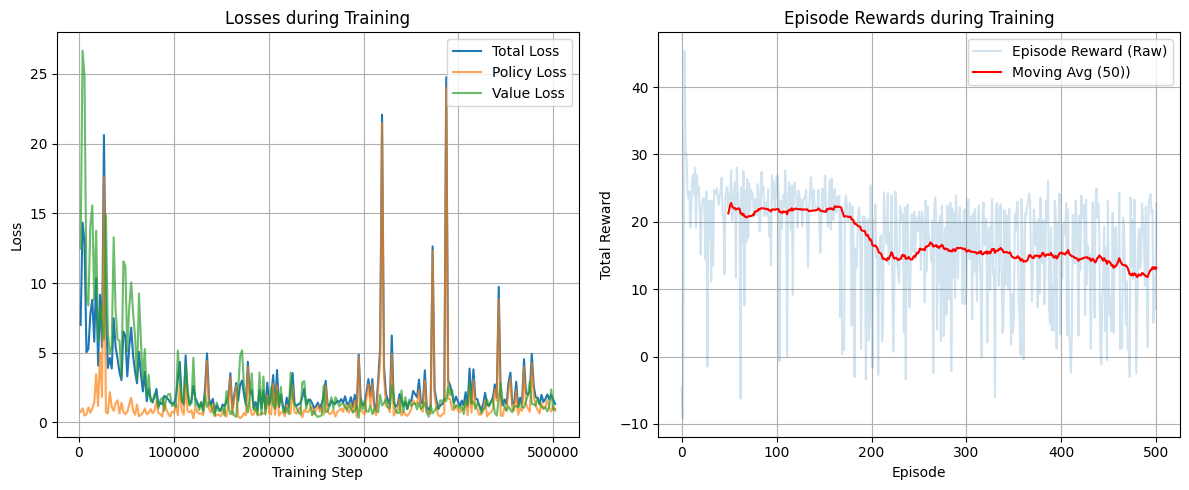

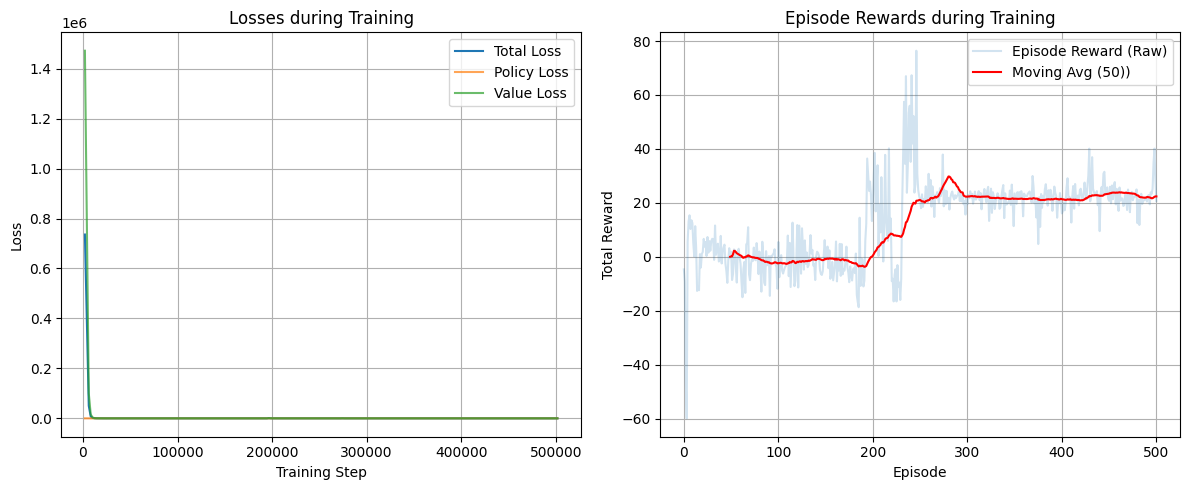

In [ ]:
raw_dir = "data/raw_pytorch/Swimmer-v4/mlp_256_raw_pytorch_20250430_225549"
icm_dir = "data/ppo_icm/Swimmer-v4/mlp_256_icm_pytorch_20250430_231021"

plot_metrics(raw_dir)
plot_metrics(icm_dir)

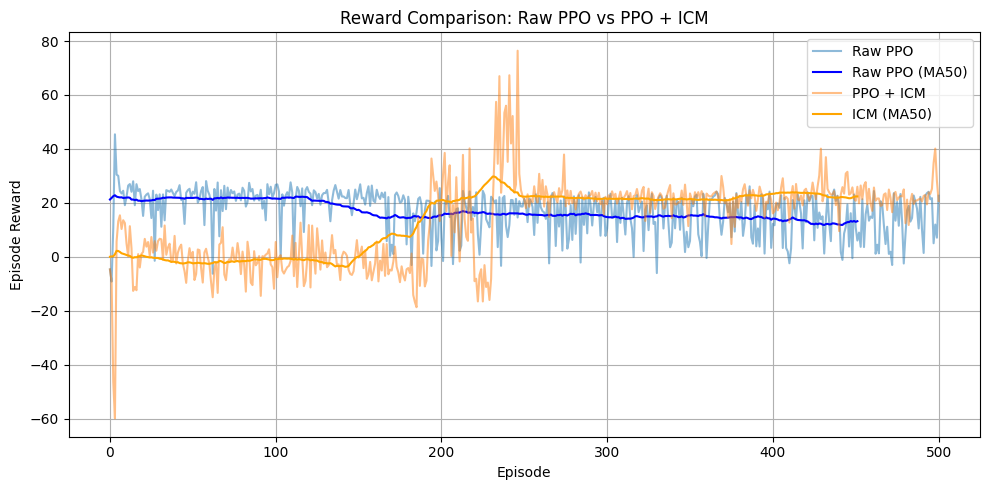

In [ ]:
compare_rewards_plot(raw_dir, icm_dir)